# Exfoliation Energy

In this notebook, we train an XGBoost regressor to predict exfoliation energies normalized by surface area, to J/M^2.

In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Dataset

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

# Descriptor selection

XenonPy and Matminer

In [4]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

# Convert to J/M^2

In [5]:
# Conversion factors from http://laser.chem.olemiss.edu/~nhammer/constants.html

data['exfoliation_energy (eV)'] = data['exfoliation_energy_per_atom (eV/atom)'] * data['atoms_object (unitless)'].apply(len)

J_per_eV = 1.60217733e-19
data['exfoliation_energy (J)'] = data['exfoliation_energy (eV)'] * J_per_eV

data['surface_area (A^2)'] = data['atoms_object (unitless)'].apply(lambda atoms: atoms.get_cell()).apply(lambda cell: np.linalg.norm(np.cross(cell[0], cell[1])))
m_per_A = 1e-10
data['surface_area (m^2)'] = data['surface_area (A^2)'] * (m_per_A**2)

data['exfoliation_energy (J/m^2)'] = data['exfoliation_energy (J)'] / data['surface_area (m^2)']

target_column = 'exfoliation_energy (J/m^2)'

# Filter out by several masks

- `element_mask` - throw away systems containing noble gases, f-blocks, or any synthetic elements
- `decomposition_mask` - keep systems with a decomposition energy < 0.5 eV/atom
- `exfoliation_mask` - keep systems with an exfoliation energy > 0 eV/atom

And finally, do a train/test split

In [6]:
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

exfoliation_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

reasonable = data[element_mask & decomposition_mask & exfoliation_mask]

In [7]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [8]:
train_x_regression = np.nan_to_num(train[xenonpy_matminer_descriptors].to_numpy())
train_y_regression = np.nan_to_num(train[target_column].to_numpy())

test_x_regression = np.nan_to_num(test[xenonpy_matminer_descriptors].to_numpy())
test_y_regression = np.nan_to_num(test[target_column].to_numpy())

# XGBoost Hyperparameter Tuning

Tune an XGBoost regressor for the exfoliation energy using Optuna.

In [9]:
current_regression = None
best_regression = None
def keep_best_regression(study, trial):
    global best_regression
    if study.best_trial == trial:
        best_regression = current_regression

def objective(trial: optuna.Trial):
    global current_regression

    SEED = trial.suggest_categorical('random', [42,1234,12345])
    objective_train_x_regression, objective_validation_x_regression, objective_train_y_regression, objective_validation_y_regression = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_regression), train_y_regression, test_size=0.25, random_state=SEED)

    current_regression = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 50),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 10),
            reg_lambda = trial.suggest_float('lambda', 0, 10),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0,1),
            subsample=trial.suggest_float('subsample', .1,1),
            learning_rate=trial.suggest_float('learning_rate', 0.001, 1),
            n_estimators=1000,
            objective='reg:pseudohubererror',
            random_state=SEED)),
    ])

    current_regression.fit(X=objective_train_x_regression, y=objective_train_y_regression,
                         **{
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.r2_score(
        y_true=objective_validation_y_regression,
        y_pred=abs(current_regression.predict(objective_validation_x_regression)),
    )

    return score

regression_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    direction='maximize'
)

regression_study.optimize(func=objective, n_trials=128, callbacks=[keep_best_regression])

[I 2021-09-23 15:49:08,116] A new study created in memory with name: no-name-fa2a0627-5ed5-426f-b461-3215ebaf4624
[I 2021-09-23 15:49:13,377] Trial 0 finished with value: 0.28936248070396364 and parameters: {'random': 1234, 'max_depth': 40, 'min_child_weight': 7.799758081188035, 'alpha': 2.7259260528264164, 'lambda': 2.764642551430967, 'colsample_bytree': 0.8018721775350193, 'subsample': 0.9623254183153347, 'learning_rate': 0.8760567021073526}. Best is trial 0 with value: 0.28936248070396364.
[I 2021-09-23 15:49:15,484] Trial 1 finished with value: 0.3936752314948032 and parameters: {'random': 12345, 'max_depth': 36, 'min_child_weight': 3.7025075479039495, 'alpha': 5.611961860656249, 'lambda': 5.030831653078097, 'colsample_bytree': 0.013768449590682241, 'subsample': 0.7955439594511367, 'learning_rate': 0.8827585494454805}. Best is trial 1 with value: 0.3936752314948032.
[I 2021-09-23 15:49:19,920] Trial 2 finished with value: 0.37658289143153734 and parameters: {'random': 1234, 'max_de

# Save summary statistics

- A parity plot for the model and the entire data range
    - Also for a subset of the range
- Model performance statistics are also printed


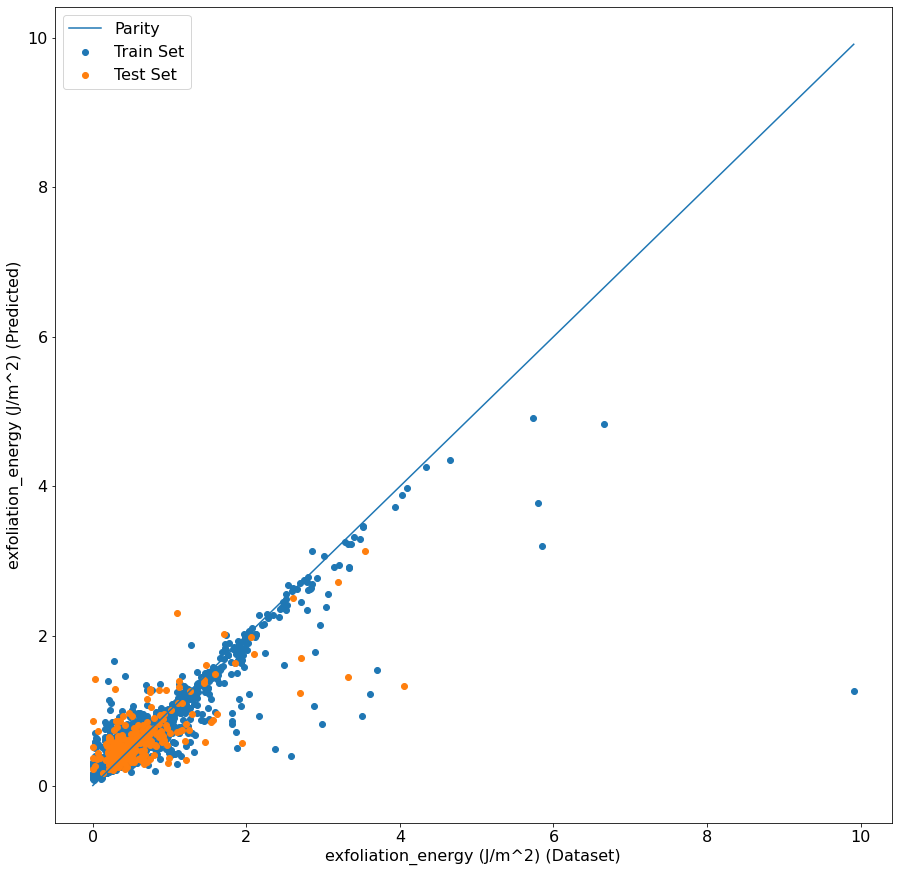

In [10]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression,
                                                test_x_regression,
                                                train_y_regression,
                                                test_y_regression,
                                                best_regression,
                                                target_column,
                                                "exfoliation_joules_per_meter.jpeg")

In [11]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_regression.predict(test_x_regression)
for key, fun in metrics.items():
    value = fun(y_true=test_y_regression, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 2.72
MAE 0.19
MSE 0.112
RMSE 0.334
MAPE 4.834
R2 0.574


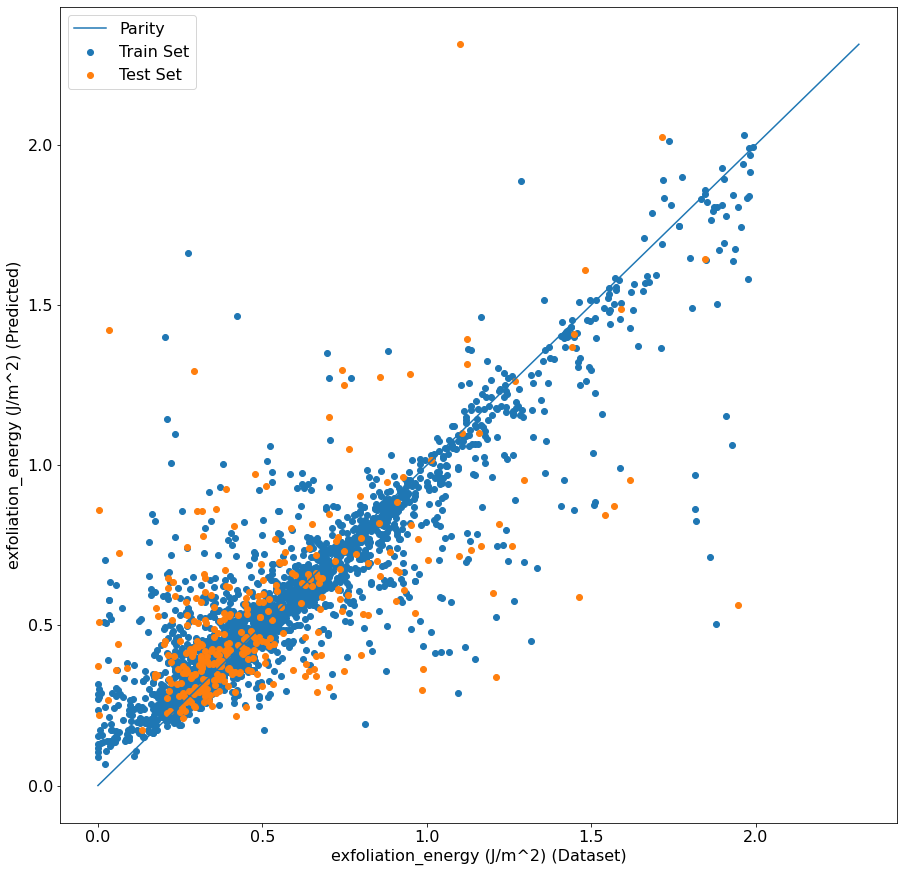

In [12]:
# Zoom in on just exfoliation energies below 2 eV
cutoff=2
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression[train_y_regression<cutoff, :],
                                                test_x_regression[test_y_regression<cutoff, :],
                                                train_y_regression[train_y_regression<cutoff],
                                                test_y_regression[test_y_regression<cutoff],
                                                best_regression,
                                                target_column,
                                                "exfoliation_joules_per_meter_lessThan2.jpeg")

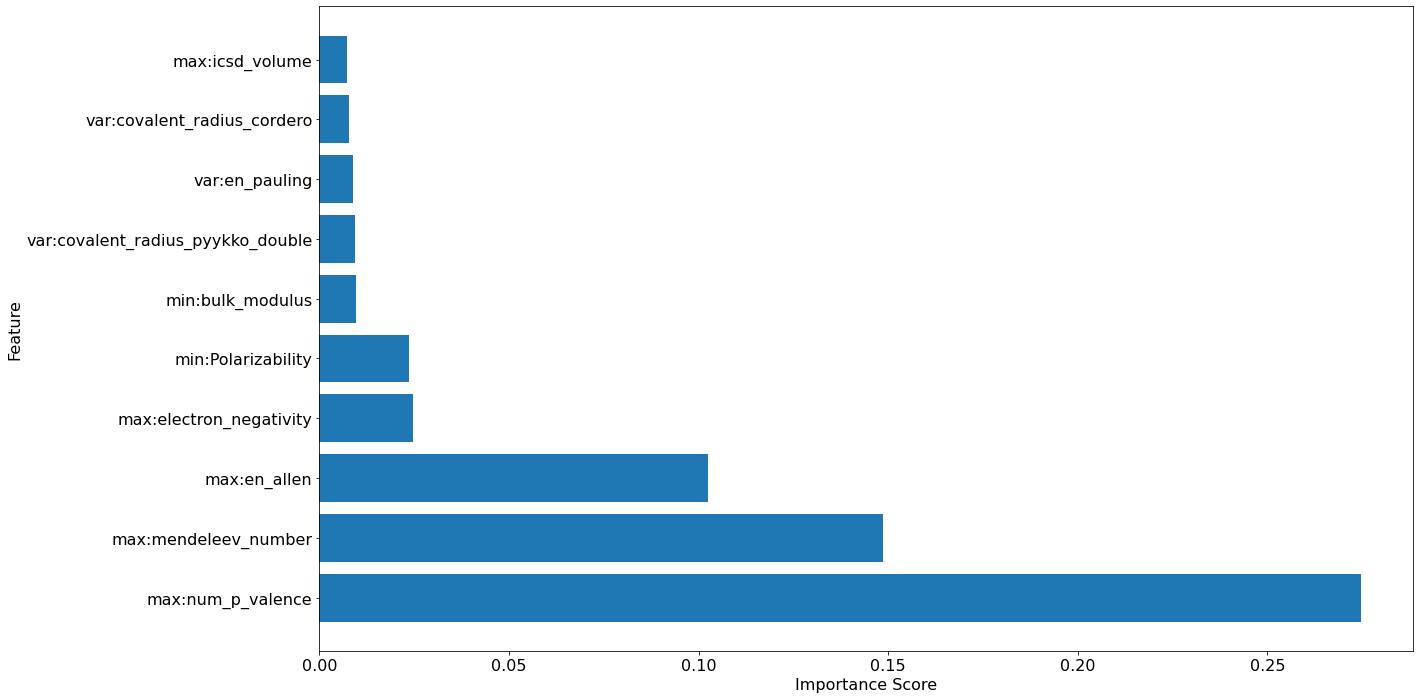

In [13]:
n_importances = 10
importances = list(zip(best_regression[1].feature_importances_, xenonpy_matminer_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))


x=10
plt.rcParams['figure.figsize'] = (2*x,x)
plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

In [14]:
cols_for_sisso = [i[1] for i in sorted_importances][:10] + ['exfoliation_energy (J/m^2)']
train[cols_for_sisso].to_csv('joules_meter_square_sisso_train.csv', index=False)
test[cols_for_sisso].to_csv('joules_meter_square_sisso_test.csv', index=False)

# SISSO

In [15]:
models = {
    'r1_1term': lambda df: 4.404873233341312e-01 + \
                           9.781965911161868e-02 * (df['min:bulk_modulus'] / df['max:en_allen']),
    'r1_2term': lambda df: 5.362243384327817e-01 + \
                           -1.798113641923983e-01 * np.sin(df['min:bulk_modulus']) + \
                           8.823903699275686e-02 * (df['min:bulk_modulus'] / df['max:en_allen']),
    'r1_3term': lambda df: 6.016831442338191e-01 + \
                           -2.927241001063905e-04 * (df['max:icsd_volume'] * df['min:bulk_modulus']) + \
                           -1.985383974054647e-01 * np.sin(df['min:bulk_modulus']) + \
                           1.860876547833066e-01 * (df['min:bulk_modulus'] / df['max:en_allen']),
    'r1_4term': lambda df: 5.705073925771592e-01 + \
                           -2.863198886084749e-04 * (df['max:icsd_volume'] * df['min:bulk_modulus']) + \
                           -1.082323743327636e-01 * np.cos(df['max:en_allen']) + \
                           -2.197625832041794e-01 * np.sin(df['min:bulk_modulus']) + \
                           1.972152349576783e-01 * (df['min:bulk_modulus'] / df['max:en_allen']),
    'r2_1term': lambda df: 5.028827080746997e-01 + \
                           3.114625532016955e+02 * ((df['min:bulk_modulus'] / df['max:icsd_volume']) / (df['max:en_allen']**3)),
    'r2_2term': lambda df: 1.024868520318417e+00 + \
                           -4.430757799985536e-13 * ((df['max:mendeleev_number']**6) * np.sqrt(df['min:Polarizability'])) + \
                           2.553498564455721e+02 * ((df['min:bulk_modulus'] / df['max:icsd_volume']) / (df['max:en_allen']**3)),
    'r2_3term': lambda df: 1.007585809890319e+00 + \
                           1.453137511190895e-01 * np.cos(df['var:en_pauling'] + df['min:bulk_modulus']) + \
                           -4.118193819656038e-13 * ((df['max:mendeleev_number']**6) * np.sqrt(df['min:Polarizability'])) + \
                           2.578671165508385e+02 * ((df['min:bulk_modulus'] / df['max:icsd_volume']) / (df['max:en_allen']**3)),
    'r2_4term': lambda df: 9.633615867872918e-01 + \
                           1.660922813669548e-01 * (np.exp(-1 * df['var:covalent_radius_pyykko_double']) / np.log(df['min:Polarizability'])) + \
                           2.096670377386976e-03 * ((df['var:en_pauling'] * df['min:Polarizability']) / np.cos(df['min:bulk_modulus'])) + \
                           -4.136201377618091e-13 * ((df['max:mendeleev_number']**6) * np.sqrt(df['min:Polarizability'])) + \
                           2.647536423788877e+02 * ((df['min:bulk_modulus'] / df['max:icsd_volume']) / (df['max:en_allen']**3))
}


for key, fun in models.items():
    train[key] = fun(train)
    test[key] = fun(test)

/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_23740/3624590230.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[key] = fun(train)
/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_23740/3624590230.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[key] = fun(test)


In [16]:
target='exfoliation_energy (J/m^2)'
train_min = min(train[target].min(), best_regression.predict(train_x_regression).min())
train_max = max(train[target].min(), best_regression.predict(train_x_regression).max())
test_min = min(test[target].min(), best_regression.predict(test_x_regression).min())
test_max = max(test[target].min(), best_regression.predict(test_x_regression).max())

for key in models.keys():
    train_min = min(train_min, train[key].min())
    train_max = max(train_max, train[key].max())
    test_min = min(test_min, test[key].min())
    test_max = max(test_max, test[key].max())

def get_r2(label, dataset):
    r2 = sklearn.metrics.r2_score(y_true=dataset[target], y_pred=dataset[label])
    return np.round(r2, 2)

In [17]:
plt.rcParams['figure.figsize'] = (7,7)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 8

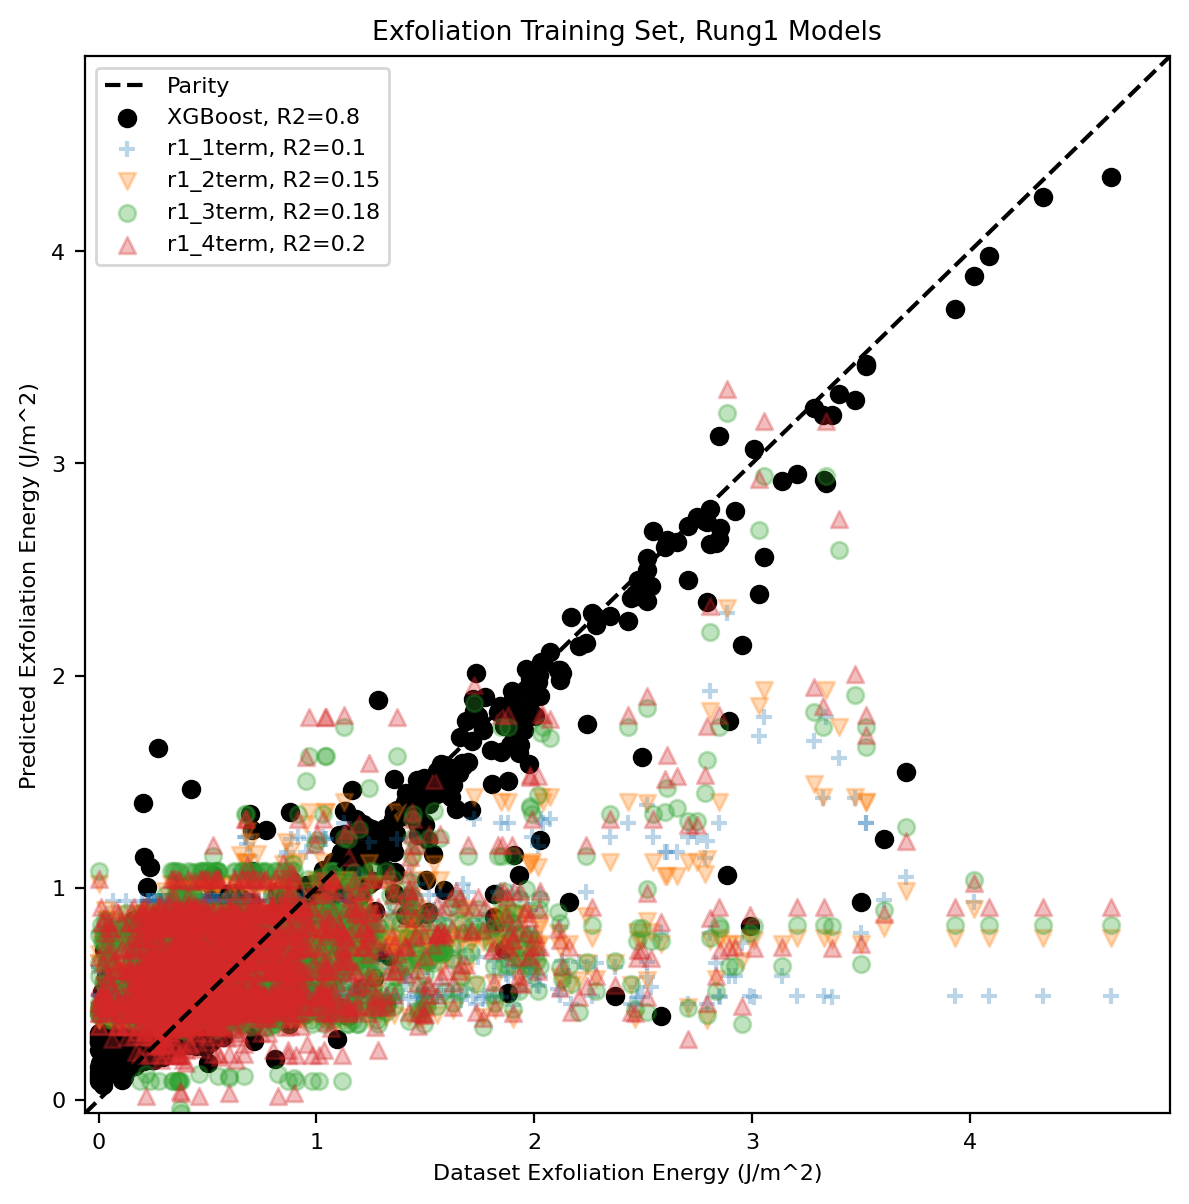

In [18]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=train[target], y_pred=best_regression.predict(train_x_regression)), 2)

plt.scatter(x=train[target], y=best_regression.predict(train_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r1_1term', 'r1_2term', 'r1_3term', 'r1_4term']:
    plt.scatter(x=train[target], y=train[model_label], label=f"{model_label}, R2={get_r2(model_label, train)}", alpha=0.3, marker=next(markers))
plt.plot([train_min, train_max], [train_min, train_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([train_min, train_max])
plt.ylim([train_min, train_max])

plt.title('Exfoliation Training Set, Rung1 Models')
plt.ylabel('Predicted Exfoliation Energy (J/m^2)')
plt.xlabel('Dataset Exfoliation Energy (J/m^2)')
plt.legend()

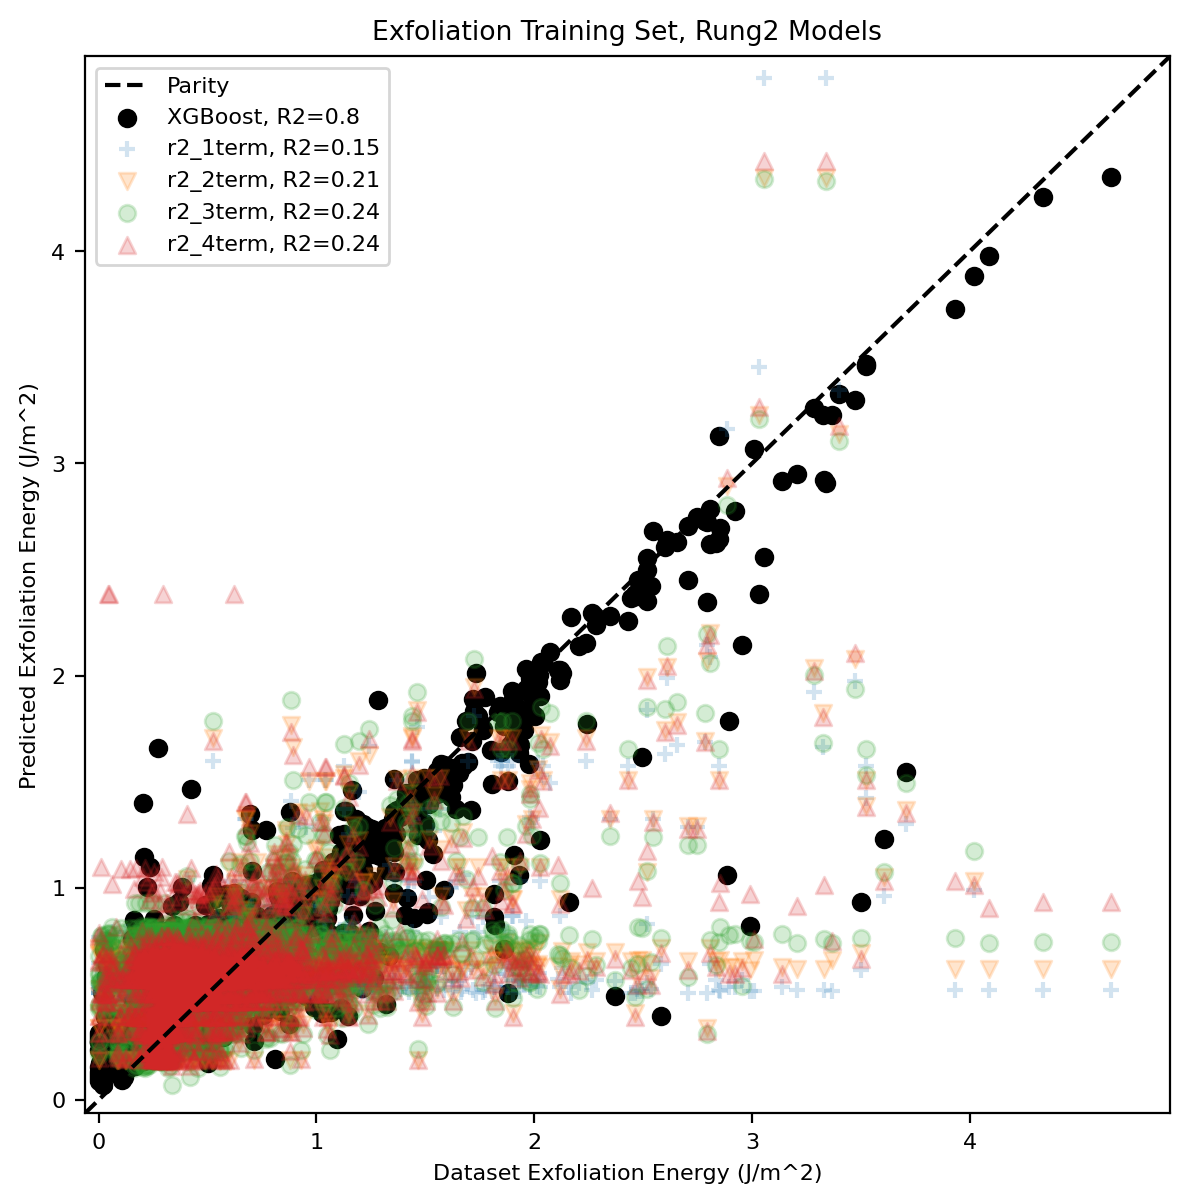

In [19]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=train[target], y_pred=best_regression.predict(train_x_regression)), 2)

plt.scatter(x=train[target], y=best_regression.predict(train_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r2_1term', 'r2_2term', 'r2_3term', 'r2_4term']:
    plt.scatter(x=train[target], y=train[model_label], label=f"{model_label}, R2={get_r2(model_label, train)}", alpha=0.2, marker=next(markers))
plt.plot([train_min, train_max], [train_min, train_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([train_min, train_max])
plt.ylim([train_min, train_max])
    
plt.title('Exfoliation Training Set, Rung2 Models')
plt.ylabel('Predicted Exfoliation Energy (J/m^2)')
plt.xlabel('Dataset Exfoliation Energy (J/m^2)')
plt.legend()

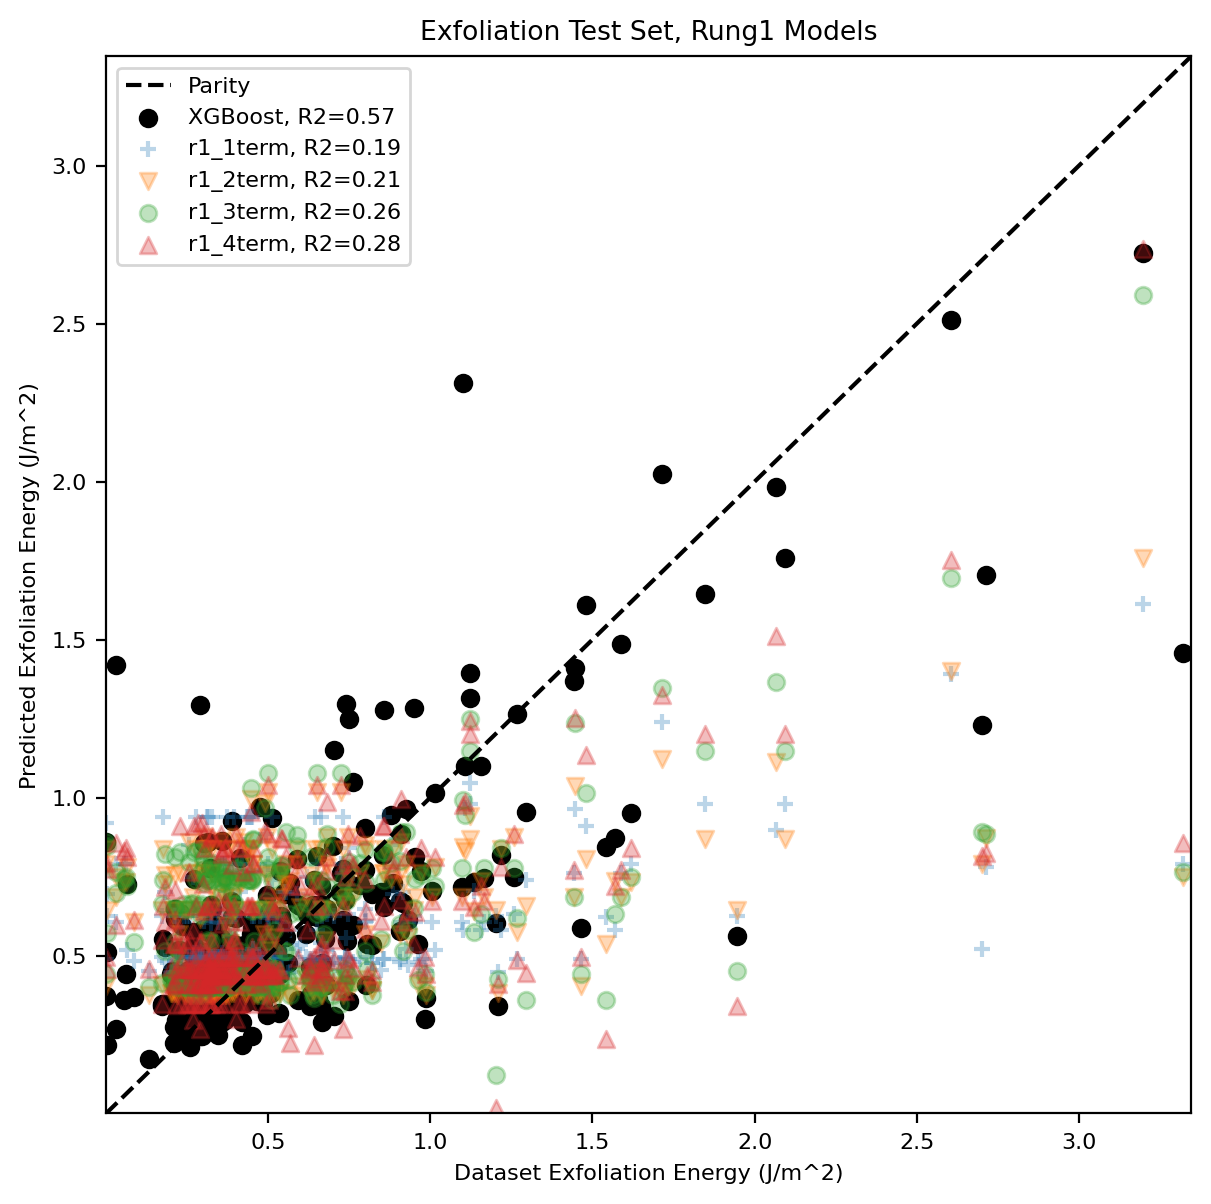

In [20]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=test[target], y_pred=best_regression.predict(test_x_regression)), 2)

plt.scatter(x=test[target], y=best_regression.predict(test_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r1_1term', 'r1_2term', 'r1_3term', 'r1_4term']:
    plt.scatter(x=test[target], y=test[model_label], label=f"{model_label}, R2={get_r2(model_label, test)}", alpha=0.3, marker=next(markers))
    
plt.plot([test_min, test_max], [test_min, test_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([test_min, test_max])
plt.ylim([test_min, test_max])

plt.title('Exfoliation Test Set, Rung1 Models')
plt.ylabel('Predicted Exfoliation Energy (J/m^2)')
plt.xlabel('Dataset Exfoliation Energy (J/m^2)')
plt.legend()

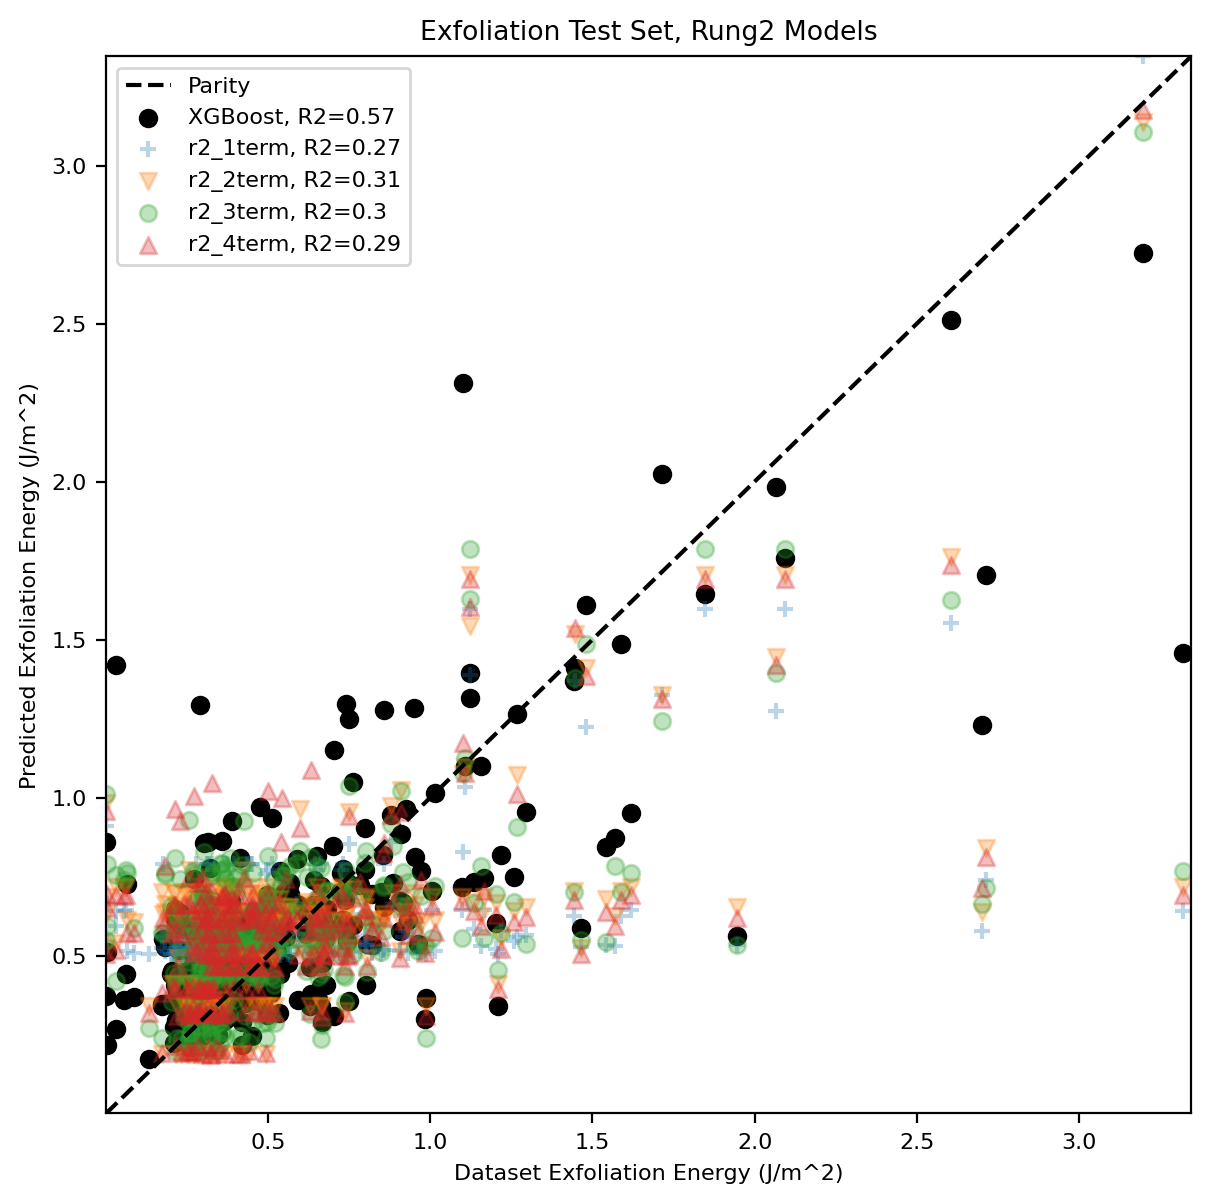

In [21]:
xgb_r2 = np.round(sklearn.metrics.r2_score(y_true=test[target], y_pred=best_regression.predict(test_x_regression)), 2)

plt.scatter(x=test[target], y=best_regression.predict(test_x_regression), label=f"XGBoost, R2={xgb_r2}", c="black")

markers = iter('+vo^')
for model_label in ['r2_1term', 'r2_2term', 'r2_3term', 'r2_4term']:
    plt.scatter(x=test[target], y=test[model_label], label=f"{model_label}, R2={get_r2(model_label, test)}", alpha=0.3, marker=next(markers))
plt.plot([test_min, test_max], [test_min, test_max], c='k', linestyle='dashed', label='Parity')
plt.xlim([test_min, test_max])
plt.ylim([test_min, test_max])

plt.title('Exfoliation Test Set, Rung2 Models')
plt.ylabel('Predicted Exfoliation Energy (J/m^2)')
plt.xlabel('Dataset Exfoliation Energy (J/m^2)')
plt.legend()